# (a)  Download Sentiment Labelled Sentences Data Set.  There are three data files under the rootfolder.yelp_labelled.txt,amazon_cells_labelled.txt and imdb_labelled.txt. Parse each file with the specifications inreadme.txt. Are the labels balanced? If not, what’s the ratio between the two labels? Explain how you process these files.

In [1]:
import pandas as pd
import numpy as np

import re
import string

import glob

import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('wordnet')

from collections import Counter

import math

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

import matplotlib.pyplot as plt


# import spacy
# import contextualSpellCheck

# nlp = spacy.load('en_core_web_sm')
# contextualSpellCheck.add_to_pipe(nlp)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/johnwaldo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/johnwaldo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Load datasets.
Reviews are placed into a dataframe with 3 features
    dataset: which file this record comes from
    msg: the string of the message
    review: Integer [0,1] representing good or bad sentiment

In [2]:
data_path = './sentiment labelled sentences/'


column_names = ['dataset','msg','review']
review_data = []

for file_path in glob.glob(data_path + "*"):
    if "labelled.txt" in file_path:
        data_set = file_path.split("/")[-1].split("_")[0]

        file = open(file_path, 'r')
        file_lines = file.readlines()
        
        for line in file_lines:

            [msg, review] = line[:-1].split("\t")

            review_data.append([data_set,msg,int(review)])
            
reviews = pd.DataFrame(data = np.array(review_data), columns = column_names)
reviews['review'] = pd.to_numeric(reviews['review'])

Now check the label distribution

In [3]:

reviews.groupby(['dataset','review']).count()


msg
dataset review     
amazon  0       500
        1       500
imdb    0       500
        1       500
yelp    0       500
        1       500

We can see in the table above that each dataset has 500 messages that are labeled 0 and 500 labeled 1. So the labels are balanced

# (b) Pick your preprocessing strategy. Since these sentences are online reviews, they may contain significant amounts of noise and garbage.  You may or may not want to do one or all of the following. Explain the reasons for each of your decision (why or why not).
# •  Lowercase all of the words.

# •  Lemmatization of all the words (i.e., convert every word to its root so that all of “running,”“run,” and “runs” are converted to “run” and and all of “good,” “well,” “better,” and “best”are converted to “good”; this is easily done using nltk.stem).

# •  Strip punctuation.

# •  Strip the stop words, e.g., “the”, “and”, “or”.

# •  Something else? Tell us about it.

We will utilize the following preprocessing function. This function will transform a string on the following jobs if they are enabled. The only function that is enabled by default is lowercase of all words.

We choose to use lower case only, remove numeric features, and all punctuation to make it more likely that like words share the same token. We decided not to use the lemmatizer because we wanted to see if tense makes an impact. For example, we could see "I love this item!" "I loved this item until...".

We also an additional job:

    "remove_numeric": will strip any numeric characters
    



In [4]:
def messagePreprocess(message, lower_only = True, lemmatizer = None,
                  remove_punctuation = False, stop_words = [],
                  remove_numeric = False):
    
    
    # Convert all words to lowercase
    if lower_only == True:
        message = message.lower()
    
    # Strip punctuation:
    if remove_punctuation == True:
        
        # Check if there is a space between the punctuation:
        message = re.sub('([.,!?()])', r' \1 ', message)
        
        message = message.translate(str.maketrans('', '', string.punctuation))

    
    # Strip words with numeric characters:
    if remove_numeric == True:
        message = ' '.join(s for s in message.split() if not any(c.isdigit() for c in s))
        
    # If not None, use the lemmatizer supplied
    if lemmatizer != None:
        message = ' '.join(lemmatizer.lemmatize(s) for s in message.split())
        
    # Remove any stop words
    message = ' '.join(s for s in message.split() if not s in stop_words)

    
    return message
        
        

Add a new column "clean_msg" that will be the output of the original message after preprocessing

In [5]:

lemma_type = "WordNet"
lemmatizer = None
if lemma_type == "Porter":
    lemmatizer = PorterStemmer()
    
elif lemma_type == "WordNet":
    lemmatizer = WordNetLemmatizer()

stop_words = []
#stop_words = stopwords.words('english')

clean_msgs = []

for i in range(len(reviews)):
    msg = reviews.iloc[i,1]
    
    clean_msg = messagePreprocess(msg,
                                  stop_words = stop_words,
                                  remove_numeric = True,
                                  remove_punctuation = True,
                                  lemmatizer = lemmatizer)
    
    clean_msgs.append(clean_msg)
    
reviews['clean_msg'] = clean_msgs

# (c) Split training and testing set.In this assignment, for each file, please use the first 400 instances for each label as the training setand the remaining 100 instances as testing set.  In total, there are 2400 reviews for training and 600 reviews for testing.

In [6]:
train_set = reviews.groupby(['dataset','review']).head(400)
test_set = reviews.groupby(['dataset','review']).tail(100)

# d) Bag of Words model. Extract features and then represent each review using bag of words model, i.e., every word in the review becomes its own element in a feature vector. In order to do this, first, make one pass through all the reviews in the training set (Explain why we can’t use testing set at this point) and build a dictionary of unique words. Then, make another pass through the review in both the training set and testing set and count up the occurrences of each word in your dictionary.  The ith element of a review’s feature vector is the number of occurrences of the ith dictionary word in the review. Implement the bag of words model and report feature vectors of any two reviews in the training set.

First we get all unique words in the train set. We only take the words in the train data and not the test data because adding any features not in the train data will have a coefficient of 0. This is because they will all be 0 and thus the model cannot learn anything from this constant feature.

In [168]:
def convertToFeatures(msgs, word_list = None, min_count = 1):
    
    # Then convert messages to words
    msg_words = [[s for s in msg.split()] for msg in msgs]

    if word_list == None:
        # Then put all the words into a single array
        word_list = [word for words in msg_words for word in words]

        # First filter out words that are seen less than min_count
        word_list = [word for word, freq in Counter(word_list).items() if freq >= min_count]

        
    # And convert to feature vectors
    msg_vectors = np.array([[msg.count(word) for word in word_list] for msg in msg_words])
    
    
    return [msg_vectors, word_list]
    


In [233]:

# Then convert both sets into feature vectors

[train_vectors, word_list] = convertToFeatures(train_set['clean_msg'].copy(), min_count = 2)
[test_vectors, word_list] = convertToFeatures(test_set['clean_msg'].copy(), word_list = word_list, min_count = 2)

# And print a few sample vectors
for i in range(2):
    print("Message: " + str(train_set['clean_msg'].iloc[i]))
    print("Vector: " + str(train_vectors[i]))
    print("")


Message: so there is no way for me to plug it in here in the u unless i go by a converter
Vector: [1 1 1 ... 0 0 0]

Message: good case excellent value
Vector: [0 0 0 ... 0 0 0]



# e) Pick your postprocessing strategy. Since the vast majority of English words will not appear in most of the reviews, most of the feature vector elements will be 0. This suggests that we need a post processing or normalization strategy that combats the huge variance of the elements in the feature vector.  You may want to use one of the following strategies.  Whatever choices you make, explain why you made the decision.
# •log-normalization. For  each  element  of  the  feature  vector x,  transform  it  into f(x)=log(x+1).
# •l1 normalization. Normalize the l1 norm of the feature vector, ˆx=x/|x| 
# •l2 normalization. Normalize the l2 norm of the feature vector,ˆx=x/‖x‖.
# •Standardize the data by subtracting the mean and dividing by the variance.

In [199]:
def postProcess(train_data, test_data, max_cap = None, strats = None):
                
    if max_cap != None:
        
        # Upper bound for any datapoint to max_cap
        train_data = np.array([[min(max_cap,f) for f in msg] for msg in train_data])
        
        test_data = np.array([[min(max_cap,f) for f in msg] for msg in test_data])
        
        
    for strat in strats:
            
        if strat == 'log_norm':
            # Add 1 to every element
            train_data = [[f+1 for f in msg] for msg in train_data]
            train_data = np.log(train_data)
            
            test_data = [[f+1 for f in msg] for msg in test_data]
            test_data = np.log(test_data)
            
        elif strat == 'l1_norm':
            row_sums = train_data.sum(axis=1)
            row_sums = np.where(row_sums<1, 1, row_sums)
            
            train_data = train_data / row_sums[:, np.newaxis]
            
            row_sums = test_data.sum(axis=1)
            row_sums = np.where(row_sums<1, 1, row_sums)
            
            test_data = test_data / row_sums[:, np.newaxis]
            
            
        elif strat == 'l2_norm':
            row_sums = np.sum(np.abs(train_data)**2,axis=1)**(1./2)
            row_sums = np.where(row_sums<1, 1, row_sums)

            train_data = train_data / row_sums[:, np.newaxis]
            
            
            row_sums = np.sum(np.abs(test_data)**2,axis=1)**(1./2)
            row_sums = np.where(row_sums<1, 1, row_sums)

            test_data = test_data / row_sums[:, np.newaxis]

    if 'standardize' in strats:
        test_data = (test_data - np.mean(train_data, axis=0)) / np.std(train_data, axis=0)
        
        
        train_data = (train_data - np.mean(train_data, axis=0)) / np.std(train_data, axis=0)
        
        

    return [train_data, test_data]
    

We only post process by standardizing each feature in order to keep the full integrity of each word and to keep the transformation of each row and column of both the train and test set consistent. We make sure to standardize the test set with respect to the deviation and mean of the train set in order to keep the transformation consistent.

** Note that for Naive Bayes we do not use standardization we want to keep the full data **


In [234]:
# List of post processing strategies to use

strats = ['standardize']
strats = []


[train_features, test_features] = postProcess(train_vectors, test_vectors, strats = strats)


# (f) Sentiment prediction. Train a naive Bayes model on the training set and test on the testing set. Report the classification accuracy and confusion matrix.

Here we will train a multinomial naive Bayes classifier
 \begin{aligned}\log p(C_{k}\mid \mathbf {x} )&\varpropto \log \left(p(C_{k})\prod _{i=1}^{n}{p_{ki}}^{x_{i}}\right)\\&=\log p(C_{k})+\sum _{i=1}^{n}x_{i}\cdot \log p_{ki}\\&=b+\mathbf {w} _{k}^{\top }\mathbf {x} \end{aligned}

We will solve for k = 1 because there is just two classes and \begin{aligned}p(C_{k} = 1 \mid x) = 1 - P(C_{k} = 0 \mid x)\end{aligned}


In [229]:
def trainMNBayes(dataset, alpha = 1):
    
    [data,target] = dataset
    
    total_vocab = len(data[0])
    
    labels, counts = np.unique(target, return_counts=True)
    
    counts = counts/sum(counts)

    label_weights = np.log(counts/sum(counts))
    
    feature_weights = []

    # Loop over message labels
    for label in labels:
        
        label_features = data[np.isin(target, label)]
        
        total_words = sum(sum(label_features))

        # Sum up columns values
        col_sums = label_features.sum(axis=0)
        
    
        label_feature_weights = np.log((col_sums + 1)/(total_words + alpha*total_vocab))
        
        feature_weights.append(label_feature_weights)

    feature_weights = np.matrix(feature_weights)

    return [label_weights, feature_weights]


In [188]:
def predictMNBayes(data, bayes_weights):
    
    preds = np.matrix(data)*bayes_weights[1].T
    
    preds += bayes_weights[0][np.newaxis,:]
    
    print(preds)
    
    
    preds = np.argmax(preds, axis=1)
    
    
    
    return np.asarray(preds).reshape(-1)
    
    

In [189]:
def plotConfusion(actuals, predictions, title = None, size = 12):
    
    cm = confusion_matrix(actuals, predictions, normalize = 'true')

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    disp = disp.plot()

    disp.figure_.set_size_inches(size, size, forward=True)
    
    if title != None:
        disp.ax_.set_title(title)

    plt.show()

[[ -27.72977512  -24.14156417]
 [ -44.21998054  -43.95544484]
 [-101.56072228 -102.90472266]
 ...
 [ -32.31408385  -34.72364448]
 [  -5.89972822   -9.17312298]
 [ -84.67524232  -90.37213673]]
The average accuracy rate is 0.8016666666666666


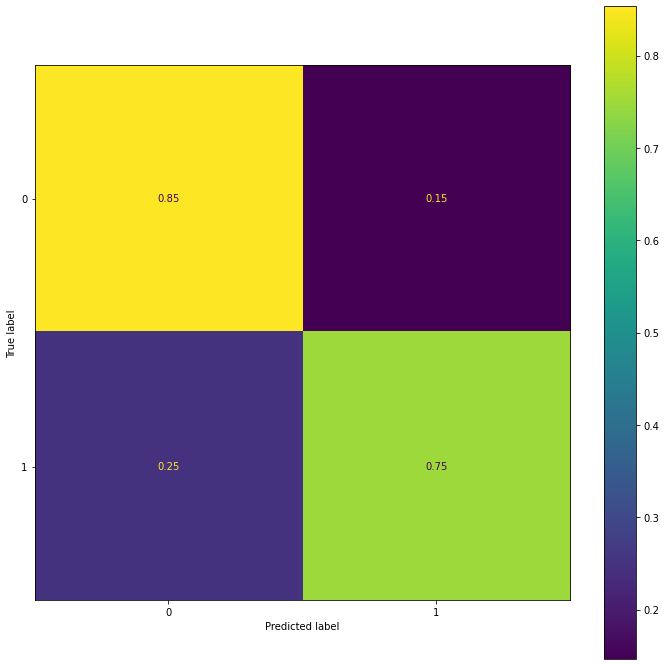

In [235]:
bayes_weights = trainMNBayes([train_features, train_set['review']], alpha = 1)

predictions = predictMNBayes(test_features, bayes_weights)

accuracy = test_set['review'] == list(predictions)
avgAcc = np.average(accuracy)

print("The average accuracy rate is " + str(avgAcc))

plotConfusion(test_set['review'],predictions)


# (g) Logistic regression. Now repeat using logistic regression classification, and compare performance (you can use existing packages here).  Try using both L2 (ridge) regularization and L1(lasso) regularization and report how these affect the classification accuracy and the coefficient vectors (hint: sklearn has a method called LogisticRegressionCV; also note that sklearn doesn’t actually have an implementation of unregularized logistic regression). Inspecting the coefficient vectors, what are the words that play the most important roles in deciding the sentiment of the reviews?

In [163]:
def evalLogisticModel(train_data, test_data, penalties, Cs):
    
    [train_features, train_reviews] = train_data
    [test_features, test_reviews] = test_data
    
    for p in penalties:

        if p == None:
            model = LogisticRegression(penalty = 'none')
        else:
            model = LogisticRegressionCV(Cs = Cs, penalty = p, solver = 'liblinear')

        model.fit(train_features, train_reviews)

        print("Penalty: " + str(p))
        if p != None:
            print("Tuned C from CV: " + str(model.C_))

        print("Coefs: " + str(model.coef_))
        print("10th percentile: " + str(np.percentile(model.coef_,10)))
        print("90th percentile: " + str(np.percentile(model.coef_,90)))
        print("Median Coef: " + str(np.median(model.coef_)))
        print("Average Coef: " + str(np.average(model.coef_)))
        print("Coef Sigma: " + str(np.std(model.coef_)))


        predictions = model.predict(test_features)
        
        accuracy = test_reviews == list(predictions)

        avgAcc = round(np.average(accuracy),3)
        
        title = "The average accuracy rate is " + str(avgAcc)

        plotConfusion(test_reviews,predictions, title, size = 5)


Penalty: None
Coefs: [[10.91041087 -7.54234191 -5.18894414 ...  1.36961672  3.47300041
   3.07513143]]
10th percentile: -4.044387892448704
90th percentile: 4.076390519880845
Median Coef: -0.0038039808467889547
Average Coef: -0.047817857540218695
Coef Sigma: 3.5440041366178954


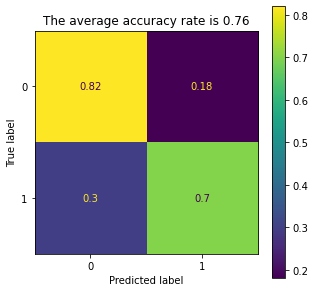

Penalty: l1
Tuned C from CV: [0.5]
Coefs: [[ 0.2697968  -0.24265456  0.         ...  0.04205627  0.0786118
   0.11108384]]
10th percentile: -0.10645116084375268
90th percentile: 0.113258228651462
Median Coef: 0.0
Average Coef: 9.962470807856086e-06
Coef Sigma: 0.11909141560064135


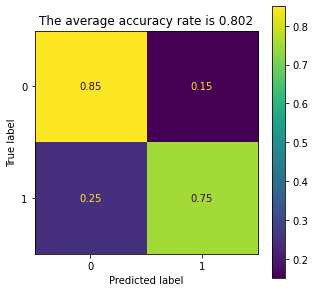

Penalty: l2
Tuned C from CV: [0.5]
Coefs: [[ 0.49203815 -0.26879892 -0.07334249 ...  0.05231159  0.182674
   0.09934515]]
10th percentile: -0.19582962104013357
90th percentile: 0.19266119162883746
Median Coef: 0.0012790451253928666
Average Coef: -0.002034930183540462
Coef Sigma: 0.17477323896129368


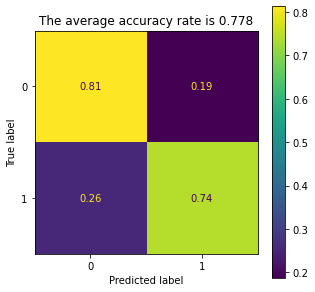

In [164]:

penalties = [None,'l1','l2']
Cs = [.5, 1, 1.5, 2.5, 5, 10]

# List of post processing strategies to use
strats = ['standardize']

[train_features, test_features] = postProcess(train_vectors, test_vectors, strats = strats)

train_data = [train_features, train_set['review']]
test_data = [test_features, test_set['review']]

evalLogisticModel(train_data, test_data, penalties, Cs)



We notice that without regularization, the coefficents have high deviations and most are non zero.

With L1 (Lasso) regularization, the vast majority of the coefficients are set to zero. So, we find that the majority of the words are not important enough or do not have a high enough correlation to review sentiment to make the cut. This doesnt squeeze the important coefficients as much as the Ridge regularization.


With L2 (Ridge) regularization, the majority of the coefficients are non zero. However, we notice that the deviation of the coeffecients is the smallest of all three types. Therefore, using Ridge all words are in play, however very few have signficant impact.

# (h) N-gram model. Similar to the bag of words model, but now you build up a dictionary of n-grams, which are contiguous sequences of words.  For example, “Alice fell down the rabbithole” would then map to the 2-grams sequence:  "Alice fell", "fell down", "down the", "the rabbit", "rabbit hole", and all five of those symbols would be members of the n-gram dictionary. Try n=2, repeat (d)-(g) and report your results.

In [223]:
def writeNGrams(msgs, n_grams):
    
    for m in range(len(msgs)):
        base_words = msgs[m].split()
   
        for n in range(2,n_grams+1):
            msgs[m] += " " + ' '.join('*'.join(base_words[s:s+n]) for s in range(len(base_words[::n])))

    return msgs

# Rewrite the message to feature function
def createNGrams(msgs, word_list = None, min_count = 1, n_grams = 1):
    
    msgs = list(msgs)
    
    msgs = writeNGrams(msgs, n_grams)

    return convertToFeatures(msgs, word_list = word_list, min_count = min_count)
    
    

In [239]:

# Create document features with n grams
[train_vectors, word_list] = createNGrams(train_set['clean_msg'].copy(),
                                          min_count = 2, n_grams = 2)

[test_vectors, word_list] = createNGrams(test_set['clean_msg'].copy(),
                                          word_list = word_list,
                                          min_count = 2, n_grams = 2)


[[ -52.52913713  -44.55729441]
 [ -70.72899589  -70.17433645]
 [-124.05528    -121.64318943]
 ...
 [ -41.81288348  -44.41162862]
 [  -6.18218693   -9.46673815]
 [-124.45709457 -129.83436053]]
The average accuracy rate is 0.7983333333333333


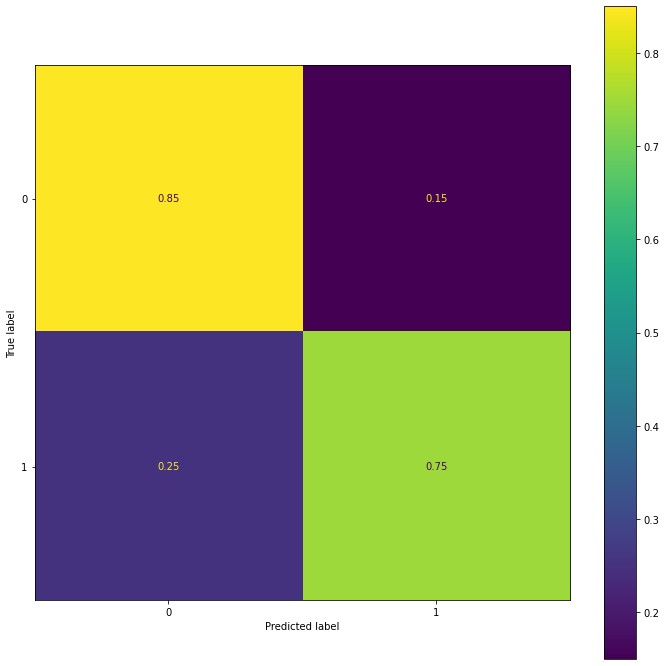

In [240]:

# Implement post processing
strats = []

[train_features, test_features] = postProcess(train_vectors, test_vectors, strats = strats)

train_data = [train_features, train_set['review']]
test_data = [test_features, test_set['review']]




bayes_weights = trainMNBayes(train_data, alpha = 1)

predictions = predictMNBayes(test_data[0], bayes_weights)

accuracy = test_data[1] == list(predictions)
avgAcc = np.average(accuracy)


print("The average accuracy rate is " + str(avgAcc))

plotConfusion(test_data[1],predictions)


In [237]:
 # Implement post processing
strats = ['log_norm','standardize']

[train_features, test_features] = postProcess(train_vectors, test_vectors, strats = strats)

train_data = [train_features, train_set['review']]
test_data = [test_features, test_set['review']]



Penalty: None
Coefs: [[ 1.53001517 -2.14610256 -0.82710186 ...  0.63042521  0.80161125
   0.26813877]]
10th percentile: -0.8688200696612993
90th percentile: 0.8901547628568581
Median Coef: -0.0019862007932970787
Average Coef: 0.0064556664891388645
Coef Sigma: 0.8039718396467136


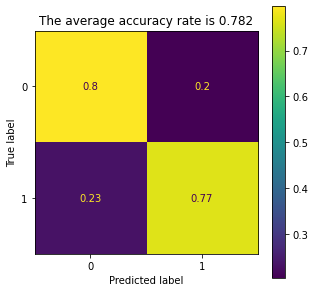

Penalty: l1
Tuned C from CV: [0.5]
Coefs: [[ 0.11664994 -0.21263299  0.         ...  0.          0.06450479
   0.        ]]
10th percentile: -0.04878798381626723
90th percentile: 0.0516417743430841
Median Coef: 0.0
Average Coef: 0.001615278976232771
Coef Sigma: 0.07855454889496985


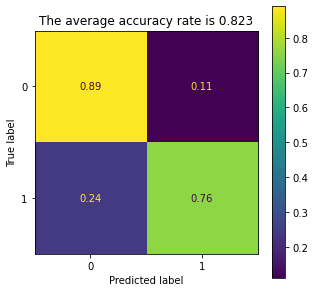

Penalty: l2
Tuned C from CV: [0.5]
Coefs: [[ 0.13483609 -0.27644057 -0.0496419  ...  0.0805458   0.08978075
   0.03169141]]
10th percentile: -0.10433160107719923
90th percentile: 0.10425105917751078
Median Coef: -0.0014855732259536796
Average Coef: -0.0004555182764200815
Coef Sigma: 0.09279840194107367


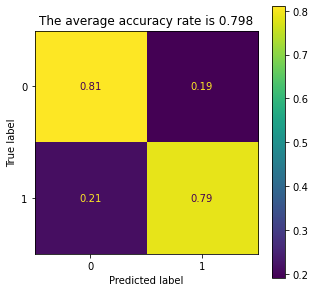

In [228]:

penalties = [None,'l1','l2']
Cs = [.5, 1, 1.5, 2.5, 5, 10]

evalLogisticModel(train_data, test_data, penalties, Cs)



# (i) Algorithms comparison and analysis. According to the above results, compare the performances of naive Bayes, logistic regression, naive Bayes with 2-grams, and logistic regression with 2-grams. Which method performs best in the prediction task and why? What do you learn about the language that people use in online reviews (e.g., expressions that will make the posts positive/negative)? Hint: Inspect the weights learned from logistic regression.

# Accuracy Summary:

# 1 Word BoW: .801
# 1 Word Logistic Regression: .760
# 1 Word Logistic Lasso Regression: .802
# 1 Word Logistic Ridge Regression: .778

# 2-Gram BoW: .782
# 2-Gram Logistic Regression:.782
# 2-Gram Logistic Lasso Regression: .823
# 2-Gram Logistic Ridge Regression: .798

# Interestingly, we see that without regularization using n grams to add more features actually leads to worse accuracy likely due to increased noise or strong covariation in the features. The n-gram Lasso regression works best because it would appear that only a few commonly used words and phrases have significant sentiment prediction power.

# Notice that the Lambda values are very high meaning that regularization is highly necessary to reduce model variance
